In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import random
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics.cluster import homogeneity_score

In [3]:
df=pd.read_csv(r"C:\Users\conta\OneDrive\Desktop\General Assembly\Projects\project-capstone\Credit cards\CleanEDAfraud.csv")
df.head()

,category,amt,gender,city_pop,is_fraud,trans_day,trans_month,trans_hour,trans_year,age_at_trans,dist
0,misc_net,4.97,F,3495,0,Tuesday,January,0,2019,20-30,40-50
1,grocery_pos,107.23,F,149,0,Tuesday,January,0,2019,30-40,10-20
2,entertainment,220.11,M,4154,0,Tuesday,January,0,2019,50-60,60 - 70
3,gas_transport,45.00,M,1939,0,Tuesday,January,0,2019,50-60,50-60
4,misc_pos,41.96,M,99,0,Tuesday,January,0,2019,30-40,40-50


In [6]:
#Checking percentage of fraud and non-fraud transactions
#Baseline is 0.994 non-fraud transactions
df.is_fraud.value_counts(normalize=True)

0    0.99479
1    0.00521
Name: is_fraud, dtype: float64

In [7]:
df.columns

Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'trans_day',
       'trans_month', 'trans_hour', 'trans_year', 'age_at_trans', 'dist'],
      dtype='object')

###  Unsupervised learning clustering techniques to detect fraud such as K-means and DBSCAN. Will take 10% sample from original data just to show the techniques.

In [5]:
df_sample=df.sample(frac=0.1, random_state=42)

In [6]:
df_sample.shape

(185239, 11)

In [7]:
df_sample.is_fraud.value_counts()

0    184245
1       994
Name: is_fraud, dtype: int64

In [8]:
df_sample.columns

Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'trans_day',
       'trans_month', 'trans_hour', 'trans_year', 'age_at_trans', 'dist'],
      dtype='object')

In [9]:
df_sample.drop(['trans_day', 'trans_month', 'trans_hour', 'trans_year', 'city_pop', 'dist'], axis=1, inplace=True)

In [11]:
# Creating dummy variables for Category

X = pd.get_dummies(df_sample, columns=['category', 'gender' ,'age_at_trans'],drop_first=True)
y = X.pop('is_fraud')

In [12]:
# MinMax scaler apply to the data

scaler = MinMaxScaler()
Xstd = scaler.fit_transform(X)

### MiniBatch K-means is an efficient way to implement K-means on a large dataset, which I will use in this exercise. To decide which amount of clusters I'm going to use, let's apply the Elbow method and see what the optimal number of clusters should be based on this method.

In [13]:
# Define the model

kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(Xstd)

MiniBatchKMeans(random_state=0)

In [14]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(Xstd).score(Xstd) for i in range(len(kmeans))]

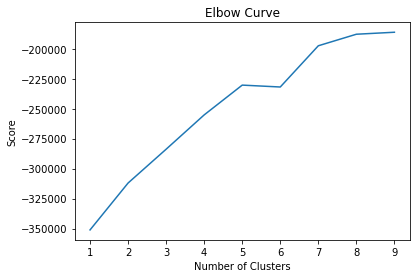

In [15]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

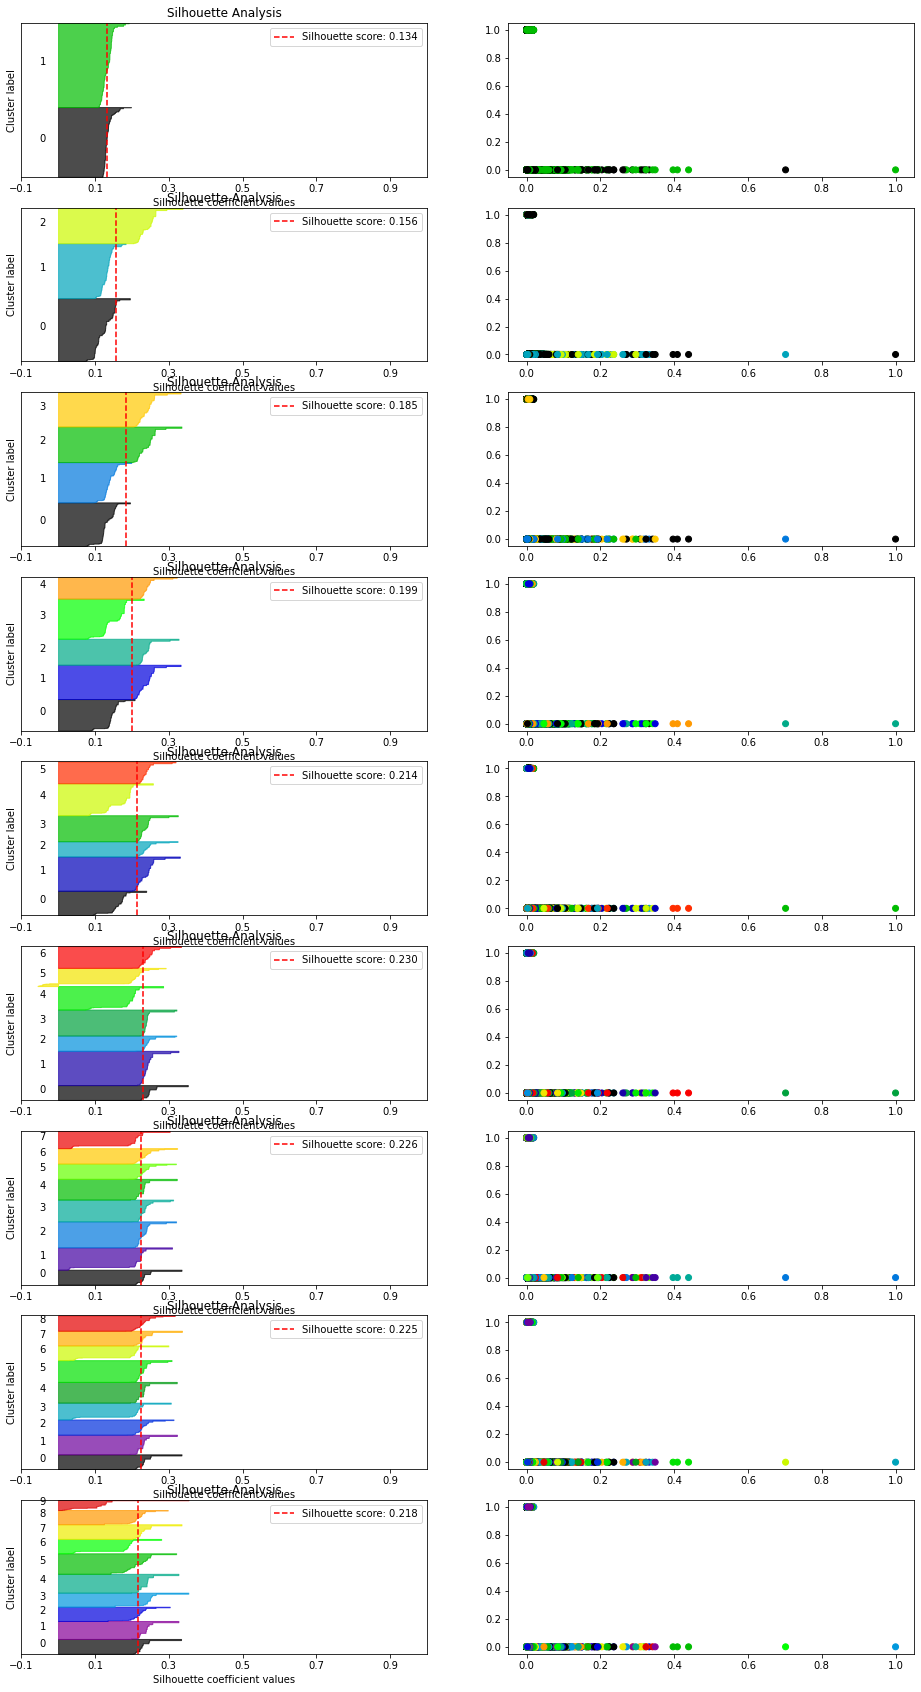

In [16]:
silhouette = []

fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(16, 30))

for k in range(2, 11):

    model = KMeans(n_clusters=k, random_state=1)
    labels = model.fit_predict(Xstd)
    silhouette.append((k, silhouette_score(Xstd, labels)))

    colors = cm.nipy_spectral(labels.astype(float) / k)
    plot_silhouette(Xstd, labels, ax=ax[k-2, 0])
    ax[k-2, 1].scatter(Xstd[:, 0], Xstd[:, 1], color=colors)

silhouette = np.array(silhouette)

### Now I can see that the optimal number of clusters should probably be at around 

In [30]:

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(Xstd, y, stratify=y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=6, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [31]:
# Define a function
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
# Obtain the ROC score

roc_auc_score(y_test, km_y_pred)

0.5085995624482595

Confusion matrix, without normalization


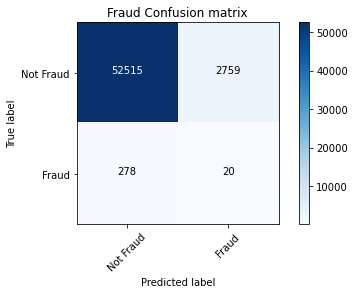

In [33]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

### DBSCAN: Density-Based Spatial Clustering of Applications with Noise

In [34]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(Xstd)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [35]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(Xstd, pred_labels):0.3f}')

Estimated number of clusters: 196
Homogeneity: 1.000
Silhouette Coefficient: 0.997


In [36]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[1528 1449 1254 1699  346  648 2243  806 1956 1274  869  976 2376 1125
 1629 2192  408 1322 1375 1403  779 1348  457  952 1272  797 1947 1925
 1985 1265 1893  478  785  847 1411  800 1189  644 1439 1051 1204  667
 1223 1679 1031 1384 1584 1471  739 2256  577 1432 1955 1144 1011  724
 1017 1684 1187  459  531  916 1144 1409 1378  534  686  789 1131 1282
  285 1084  673 2236 2052  995  720 2043  763 2393  814  834 1342  533
 1222 1207  920 1175  140  601  483 1340  786 1510  743 1363 1212 1160
 2634 1304  775 1382  762 1132 1516  882  382  573 1302  923 2442  564
 1089 1977 1650 1556 1494  280  758  788 1078  987  217  466  867 1067
 1186  244  648 1255 1440  971 1170  816  960  174  692 1893 1352  584
  570  349  600  680  577  146 1310  744  456 1307 1315  849  799  315
  594  306  108  263 1068  543  712  339  221  630  937  210  553  246
  231  458  802  563  549  165  726  328  305  399  450  296  671  233
  839  206  115  184  316  188  101  161  255  107  131  229  104  149]


In [37]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [38]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [188 194 191]


In [39]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [101 104 107]


In [40]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

In [41]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud      0     1
Actual Fraud              
0              16599  1274
1              21646     0
2              17143     0
3              16934     0
4              22711     0
5              23362  1348
6              16002  1322
7              17651     0
8              17148     0
9              12099     0


In [42]:
df_sample

,category,amt,gender,is_fraud,age_at_trans
1541144,gas_transport,59.91,M,0,40-50
1731581,shopping_pos,3.96,M,0,30-40
354659,gas_transport,51.17,F,0,70 - Above
1493788,shopping_pos,2.06,F,0,20-30
468148,travel,6.58,M,0,70 - Above
...,...,...,...,...,...
858210,food_dining,187.30,F,0,30-40
532155,shopping_pos,6.55,M,0,50-60
916941,grocery_pos,63.51,M,0,50-60
1305269,food_dining,88.58,F,0,30-40


### Anomaly detection with Isolation Forest Algorithm  compare to Local Outlier Factor(LOF) Algorithm and OneClassSVM. Will take 10% sample from original data just to show the techniques.

In [43]:
#Determine the number of fraud and valid transactions in the dataset
Fraud =df_sample[df_sample['is_fraud']==1]
Valid = df_sample[df_sample['is_fraud']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [44]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.005394990366088632
Fraud Cases : 994
Valid Cases : 184245


In [49]:
X = pd.get_dummies(df_sample, columns=['category', 'gender', 'age_at_trans'],drop_first=True)
Y = X.pop('is_fraud')

In [51]:
#Define the outlier detection methods
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
}

In [52]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine": 
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 1566
Accuracy Score :
0.9915460567159183
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184245
           1       0.21      0.22      0.21       994

    accuracy                           0.99    185239
   macro avg       0.60      0.61      0.61    185239
weighted avg       0.99      0.99      0.99    185239

Local Outlier Factor: 1970
Accuracy Score :
0.9893650905046993
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    184245
           1       0.01      0.01      0.01       994

    accuracy                           0.99    185239
   macro avg       0.50      0.50      0.50    185239
weighted avg       0.99      0.99      0.99    185239

Support Vector Machine: 44421
Accuracy Score :
0.7601962869590098
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.